In [1]:
!pip install pandas_datareader
!pip install --upgrade pandas

In [2]:
import pandas as pd
import datetime as dt
from pandas_datareader import data
import mplfinance as mpf

#apikey = '取得したAPIキー'
apikey = 'KDDTQTNE9OTMD4V4.'
symbol = 'EURUSD'

start = dt.date(2011,1,1)
end = dt.date(2021,1,30)

df = data.DataReader(symbol,'av-daily',start,end, api_key=apikey)

In [3]:
df['volume']=0.1 

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

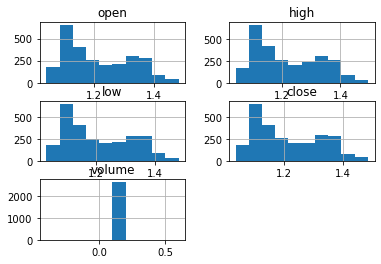

In [4]:
df.hist()

In [5]:
import numpy
#df = df.apply(numpy.log)
from scipy.stats import boxcox
df2,_ = boxcox(df['close'])

In [6]:
df=df.assign(open=df2,high=df2,low=df2,close=df2)

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

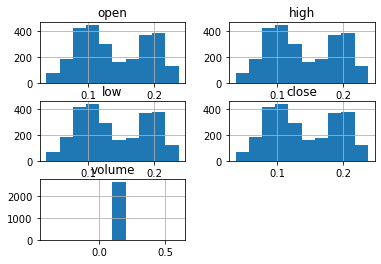

In [7]:
df.hist()

In [8]:
wsize=80 #サンプル期間
after=10 #最終レコード＋α
change_large = 4 #変化大　4%

In [9]:
df.index = pd.DatetimeIndex(df.index)

alldata =[]

for time in range(len(df)-wsize-1):
    try:
        dfspan = df[time:time+wsize]
        dflast = df.at[df.index[time+wsize], 'close']
        dfafter = df.at[df.index[time+wsize+after], 'close']
        changerate=(dfafter-dflast)/dflast*100#変化率
    
        if changerate>0:
            if changerate>change_large:
                dflabel="++"
#            elif changerate>change_small:
#                dflabel="+"
            else:
                dflabel="0"
        else:
            if changerate*-1>change_large:
                dflabel="--"
#            elif changerate*-1>change_small:
#                dflabel="-"
            else:
                dflabel="0"
        alldata.append({"df":dfspan,"label":dflabel})
    except:
        pass

In [12]:
import os
# Path to the train folder
new_dir_path = './train/'
for i in ['--','0','++']:
    os.mkdir(new_dir_path+i)

In [ ]:
import tqdm
import matplotlib as mpl

sma_s= 15
sma_m= 30

cs  = mpf.make_mpf_style(base_mpl_style='dark_background',gridcolor="#000000",mavcolors=['#00ff00','#0000ff'], facecolor="#000000")

for i in tqdm.tqdm(range(len(alldata))):
    mpf.plot(alldata[i]['df'],savefig= new_dir_path + alldata[i]['label']+ '/'\
             + str(i) + 'test.png',mav=(sma_s,sma_m),figsize=(2.5,2.5), type='line',\
             figratio=(12,4),style=cs,axisoff=True,\
             linecolor='#ff0000',tight_layout=True)


 16%|███████▏                                      | 400/2540 [00:22<02:00, 17.83it/s]

In [ ]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

#画像データをImageFolderを使って取込みする
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

images = ImageFolder( new_dir_path, transform = ImageTransform(mean, std))

In [ ]:
import torch.utils.data as data

#1バッチに含む画像の枚数を指定する
batch_size = 64

#ImageFolderで取り込んだ画像からデータローダーを作成する
train_dataloader = data.DataLoader(images, batch_size = batch_size, shuffle = True)

In [ ]:
#データローダから、画像とラベルのテンソルを取り出す。
imgs, labels = iter(train_dataloader).next()

#バッチから取り出した画像の大きさを確認する
print("image shape ==>;",imgs[0].shape)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#バッチから取り出した画像のイメージとラベルを表示する
pic = transforms.ToPILImage(mode='RGB')(imgs[0])
plt.imshow(pic)
print("Label is ",labels[0].numpy())

In [ ]:
#バッチから取り出した画像のイメージとラベルを表示する
pic = transforms.ToPILImage(mode='RGB')(imgs[63])
plt.imshow(pic)
print("Label is ",labels[63].numpy())

In [ ]:
# 学習データ、検証データに 8:2 の割合で分割する。
train_size = int(0.8 * len(images))
val_size = len(images) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    images, [train_size, val_size]
)

In [ ]:
#1バッチに含む画像の枚数を指定する
batch_size = 64

#ImageFolderで取り込んだ画像からデータローダーを作成する
dataloaders = {
  'train': data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
  'valid': data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(val_dataset)
}

In [ ]:
from torchvision import models, transforms
import torch.nn as nn
vgg16 = models.vgg16(pretrained=True)

# 全結合層の変更(最終層の出力を2にする)
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 3),
)

In [ ]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# 出力層の変更
#num_ftrs = vgg16.classifier[6].in_features
#vgg16.classifier[6] = torch.nn.Linear(num_ftrs,  out_features=3)

net_ft1 = vgg16.to(device)

# 損失関数および学習パラメーターの定義
criterion = torch.nn.CrossEntropyLoss()

# 訓練モードに設定
net_ft1.train()

# ファインチューニングで学習させるパラメータを、変数param_to_updateに格納する
param_to_update_1 = []
param_to_update_2 = []
param_to_update_3 = []

# 学習させるパラメータ名
update_param_names_1 = ['features']
update_param_names_2 = ['classifier.0.weight','classifier.0.bias','classifier.3.weight','classifier.3.bias']
update_param_names_3 = ['classifier.6.weight','classifier.6.bias']



In [ ]:
# 最適化手法の設定
optimizer = torch.optim.SGD([
    {'params':param_to_update_1,'lr':1e-4},
    {'params':param_to_update_2,'lr':5e-4},
    {'params':param_to_update_3,'lr':1e-3},
    ],momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name,param in net_ft1.named_parameters():
    print(name)
    if update_param_names_1[0] in name:
        param.requires_grad = True
        param_to_update_1.append(param)
    elif name in update_param_names_2:
        param.requires_grad = True
        param_to_update_2.append(param)
    elif name in update_param_names_3:
        param.requires_grad = True
        param_to_update_3.append(param)
    else:
        param.requires_grad = False

In [ ]:
num_epochs = 5
acc_history_ft1 = {'train': [], 'valid': []}

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            net_ft1.train()
        else:
            net_ft1.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = net_ft1(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        acc_history_ft1[phase].append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')


fig = plt.figure()
ax = fig.add_subplot()
ax.plot([a.cpu().numpy() for a in acc_history_ft1['train']], label='train')
ax.plot([a.cpu().numpy() for a in acc_history_ft1['valid']],label='valid')
ax.legend()
ax.set_ylim(0, 1)

In [ ]:
torch.save(net_ft1.state_dict(), 'model_state.pth')